In [1]:
import pandas as pd
import numpy as np
import time
import gc
import psutil
import os

# Stage 1

In [2]:
%reload_ext autoreload
%autoreload 2

## 0. Import the data as a pandas dataframe

In [3]:
from stage_1 import load_data
DATA_PATH = "P2data3466.csv"
df = load_data(DATA_PATH)

Data loaded from P2data3466.csv.


## 1. Identify and remove any data rows that make no sense

In [4]:
from stage_1 import drop_empty_rows

print(f"Before removing, there are {df.shape[0]} rows")
df = drop_empty_rows(df)
print(f"After removing, there are {df.shape[0]} rows")


Before removing, there are 499 rows
Analyzing missing values in rows...
Missing values in row (top 10 most empty rows): 
202    4
204    4
207    4
223    4
64     2
66     2
95     2
431    2
93     2
92     2
dtype: int64
Removing all rows that have less than 2 non-NA values.

Rows after removal: 495
After removing, there are 495 rows


## 2. Replace any missing values in T3 and T4 with average values for their specific level


In [5]:
from stage_1 import replace_missing_with_group_mean

df['T3'] = replace_missing_with_group_mean(df=df, col='T3')
df['T4'] = replace_missing_with_group_mean(df=df, col='T4')

Replacing missing values in the 'T3' column with the group mean based on the 'Level' column.
Replacement complete.
Replacing missing values in the 'T4' column with the group mean based on the 'Level' column.
Replacement complete.


In [6]:
df[['T3', 'T4']].isna().sum()

T3    0
T4    0
dtype: int64

## 3. Deduce the adjustment applied to T3 and T4, and write code that makes the same adjustment for any T3 and T4 values that you replaced in Step 2


To show the relation between T3 and T3adjusted I will plot them on a scatter plot.

My hipothesis is that the "adjusted" columns are logarithms of original data, because in the above plots zeros are corresponding to zeros, any halue lower than zero is rather negative with high slope, and for higher values the slope is getting flatter and flatter.

/Users/mateusz/miniforge3/envs/ds/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mateusz/miniforge3/envs/ds/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


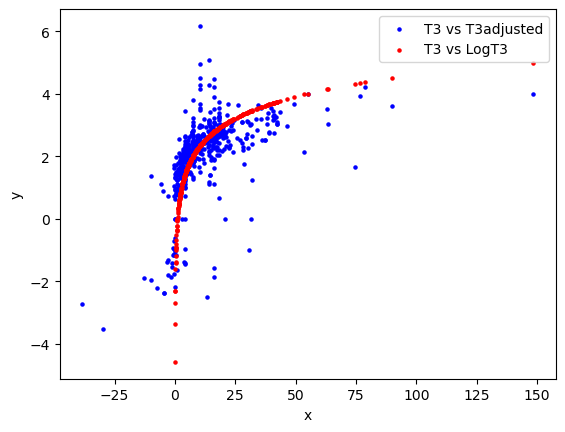

In [7]:
from stage_1 import scatter_plots

df['LogT3'] = np.log(df['T3'])
scatter_plots(
    df, 
    pairs=(
       ('T3', 'T3adjusted'),
       ('T3', 'LogT3')
    )
)

/Users/mateusz/miniforge3/envs/ds/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mateusz/miniforge3/envs/ds/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


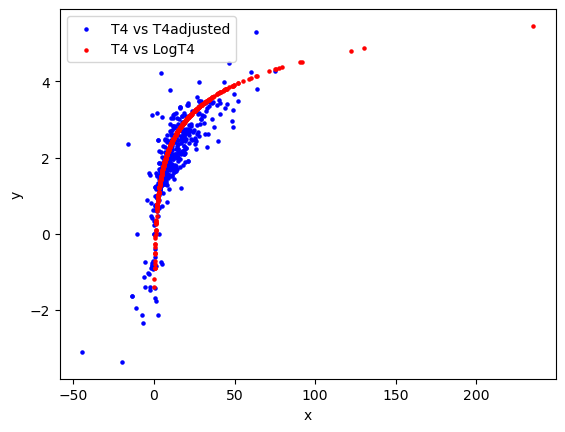

In [8]:
df['LogT4'] = np.log(df['T4'])
scatter_plots(
    df, 
    pairs=(
       ('T4', 'T4adjusted'),
       ('T4', 'LogT4')
    )
)

I see that logarithm is quite good approximation, but it doesn't fit the data as good as it should.
To fix this I'll implement slightly more complex model than pure logarithm.

$
y = log(\sum_{i=0}^{n} x^{i} \omega_{i})
$

to achieve this i will solve this polynomial equation

$
e^y = \sum_{i=0}^{n} x^{i} \omega_{i}
$

using `np.polyfit`

### T3

Polynomial Equation: y = (7.371 * x^0) + (0.571 * x^1) + (-0.002 * x^2)


/Users/mateusz/Korepetycje/2023_12_05_Martyna_Jakóbczyk_ml_intro/assignment_2/stage_1.py:95: RuntimeWarning: invalid value encountered in log
  filtered_df[f'{col_y}_pred'] = np.log(np.polyval(p=params, x=filtered_df[col_x]))


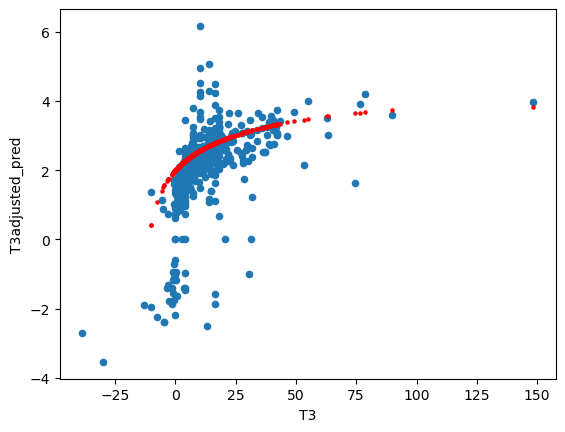

In [9]:
from stage_1 import plot_polyfit_scatter, display_polynomial_equation
t3_params = plot_polyfit_scatter(df, 'T3', 'T3adjusted', degree=2)
display_polynomial_equation(t3_params)

/Users/mateusz/Korepetycje/2023_12_05_Martyna_Jakóbczyk_ml_intro/assignment_2/stage_1.py:127: RuntimeWarning: invalid value encountered in log
  df[f'{col}_pred'] = np.log(np.polyval(p=params, x=df[col]))


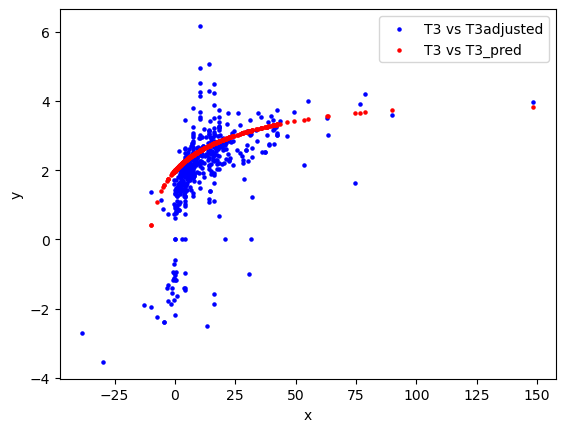

In [10]:
from stage_1 import calculate_polynomial_equation

df = calculate_polynomial_equation(df=df, col='T3', params=t3_params)
scatter_plots(
    df=df,
    pairs=(
        ('T3', 'T3adjusted'),
        ('T3', 'T3_pred')
    )
)



### T4

Polynomial Equation: y = (3.457 * x^0) + (0.329 * x^1) + (0.011 * x^2)


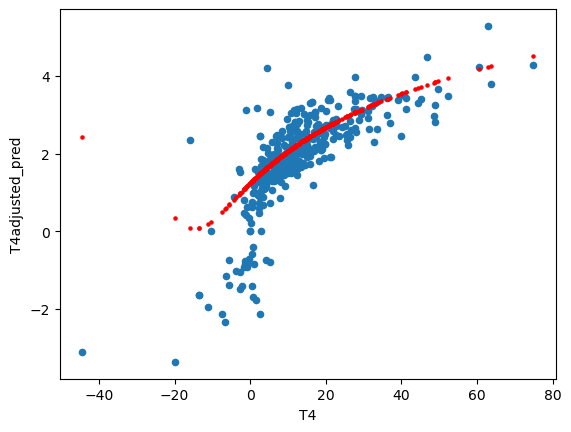

In [11]:
t4_params = plot_polyfit_scatter(df, 'T4', 'T4adjusted', degree=2)
display_polynomial_equation(t4_params)

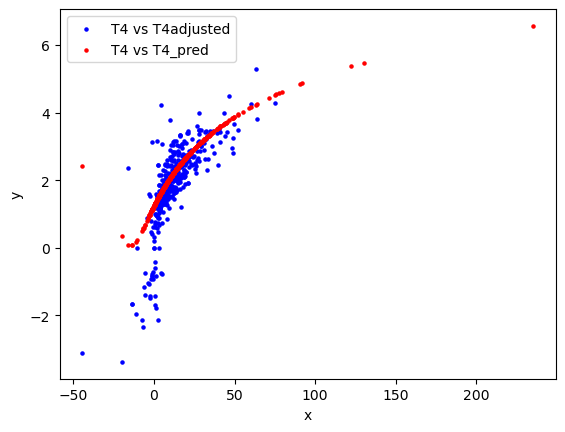

In [12]:
df = calculate_polynomial_equation(df=df, col='T4', params=t4_params)
scatter_plots(
    df=df,
    pairs=(
        ('T4', 'T4adjusted'),
        ('T4', 'T4_pred')
    )
)

In [13]:
df.isna().sum()

Level           0
T4              0
T3              0
T3adjusted      2
T4adjusted    101
LogT3          29
LogT4          35
T3_pred         3
T4_pred         0
dtype: int64

fill missing values using polynomial model prediction

In [14]:
df.T3adjusted.fillna(df['T3_pred'], inplace=True)
df.T4adjusted.fillna(df['T4_pred'], inplace=True)

df.isna().sum()

Level          0
T4             0
T3             0
T3adjusted     0
T4adjusted     0
LogT3         29
LogT4         35
T3_pred        3
T4_pred        0
dtype: int64

## 4. Write code - without using pandas.describe() - that presents a table of descriptive statistics for each column, then compare you results to those obtained using pandas.describe()

In [15]:
from stage_1 import describe
df = df[['Level', 'T4', 'T3', 'T3adjusted', 'T4adjusted']]

describe(df=df)

,Level,T4,T3,T3adjusted,T4adjusted
count,495.000000,495.000000,495.000000,495.000000,495.000000
mean,34.515152,15.051225,12.162835,2.013497,2.012689
std,62.801236,19.501783,14.620102,1.269730,1.240190
min,5.000000,-44.400000,-38.400000,-3.541014,-3.373731
25%,10.000000,4.450000,3.980581,1.625184,1.488806
50%,20.000000,10.945455,8.000000,2.204470,2.028751
75%,30.000000,19.500000,16.334107,2.696192,2.718596
max,400.000000,235.200000,148.400000,6.172756,6.563477


In [16]:
df.describe()

,Level,T4,T3,T3adjusted,T4adjusted
count,495.000000,495.000000,495.000000,495.000000,495.000000
mean,34.515152,15.051225,12.162835,2.013497,2.012689
std,62.801236,19.501783,14.620102,1.269730,1.240190
min,5.000000,-44.400000,-38.400000,-3.541014,-3.373731
25%,10.000000,4.450000,3.980581,1.625184,1.488806
50%,20.000000,10.945455,8.000000,2.204470,2.028751
75%,30.000000,19.500000,16.334107,2.696192,2.718596
max,400.000000,235.200000,148.400000,6.172756,6.563477


## 5. Write code that identifies any repeated rows or confirms that there are none

In [17]:
from stage_1 import detect_repeated_rows

detect_repeated_rows(df)

There are 20 duplicated rows in the DataFrame.
